In [1]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
import matplotlib.pyplot as plt
from pyspark.ml.clustering import KMeans
import pandas as pd
import numpy as np

In [2]:
spark=SparkSession.builder\
    .master("local[*]")\
    .appName("C3")\
    .getOrCreate()

In [3]:
sc=spark.sparkContext

In [4]:
data=sc.textFile("C3.txt")

In [5]:
from numpy import array
data = data.map(lambda line: [float(x) for x in line.split('\t')]).cache() 

In [6]:
df = spark.createDataFrame(data,["x","y"])
df.show()

+-----+----+
|    x|   y|
+-----+----+
|31.95|7.95|
|31.15| 7.3|
|30.45|6.65|
| 29.7| 6.0|
| 28.9|5.55|
|28.05| 5.0|
| 27.2|4.55|
|26.35|4.15|
| 25.4|3.85|
| 24.6| 3.6|
| 23.6| 3.3|
|22.75|3.15|
|21.85|3.05|
| 20.9| 3.0|
| 20.0| 2.9|
| 19.1| 3.0|
| 18.2| 3.2|
| 17.3|3.25|
|16.55| 3.5|
| 15.7| 3.7|
+-----+----+
only showing top 20 rows



In [7]:
from pyspark.ml.feature import VectorAssembler

vecAssembler = VectorAssembler(inputCols=["x", "y"], outputCol="features")
new_df = vecAssembler.transform(df)
new_df.show()

+-----+----+------------+
|    x|   y|    features|
+-----+----+------------+
|31.95|7.95|[31.95,7.95]|
|31.15| 7.3| [31.15,7.3]|
|30.45|6.65|[30.45,6.65]|
| 29.7| 6.0|  [29.7,6.0]|
| 28.9|5.55| [28.9,5.55]|
|28.05| 5.0| [28.05,5.0]|
| 27.2|4.55| [27.2,4.55]|
|26.35|4.15|[26.35,4.15]|
| 25.4|3.85| [25.4,3.85]|
| 24.6| 3.6|  [24.6,3.6]|
| 23.6| 3.3|  [23.6,3.3]|
|22.75|3.15|[22.75,3.15]|
|21.85|3.05|[21.85,3.05]|
| 20.9| 3.0|  [20.9,3.0]|
| 20.0| 2.9|  [20.0,2.9]|
| 19.1| 3.0|  [19.1,3.0]|
| 18.2| 3.2|  [18.2,3.2]|
| 17.3|3.25| [17.3,3.25]|
|16.55| 3.5| [16.55,3.5]|
| 15.7| 3.7|  [15.7,3.7]|
+-----+----+------------+
only showing top 20 rows



kmeans++

In [9]:
cost = np.zeros(25)
K = range(2, 25)
for k in K:
    pkm = KMeans(initMode='k-means||').setK(k).setSeed(1).setFeaturesCol("features")
    model = pkm.fit(new_df)
    cost[k] = model.summary.trainingCost

Text(0.5, 1.0, 'Kmeans++ Cost C3')

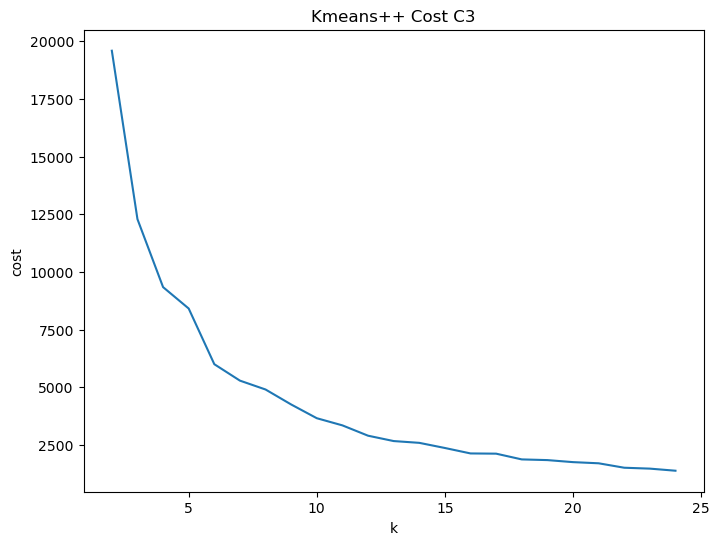

In [10]:
# plot cost-cluster diagram
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,25),cost[2:25])
ax.set_xlabel('k')
ax.set_ylabel('cost')
plt.title('Kmeans++ Cost C3')

In [11]:
k = 6
pkm = KMeans(initMode='k-means||').setK(k).setFeaturesCol("features")
model = pkm.fit(new_df)
centers = model.clusterCenters()
transformed=model.transform(new_df)
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[15.80671642  9.43358209]
[15.51875 25.9125 ]
[26.13301887  9.95849057]
[20.39433962 18.72264151]
[27.39390244 23.05      ]
[ 8.18017241 16.65258621]


In [12]:
dfcent = pd.DataFrame(centers, columns=['x', 'y'])
dfp = new_df.toPandas()
dfp=dfp.iloc[:, [0,1]].values
y_kmeans=transformed.toPandas()['prediction']

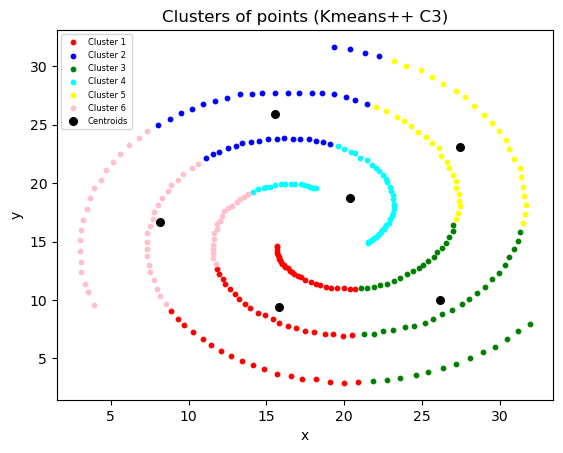

In [13]:
#6 Visualising the clusters
plt.scatter(dfp[y_kmeans==0, 0], dfp[y_kmeans==0, 1], s=10, c='red', label ='Cluster 1')
plt.scatter(dfp[y_kmeans==1, 0], dfp[y_kmeans==1, 1], s=10, c='blue', label ='Cluster 2')
plt.scatter(dfp[y_kmeans==2, 0], dfp[y_kmeans==2, 1], s=10, c='green', label ='Cluster 3')
plt.scatter(dfp[y_kmeans==3, 0], dfp[y_kmeans==3, 1], s=10, c='cyan', label ='Cluster 4')
plt.scatter(dfp[y_kmeans==4, 0], dfp[y_kmeans==4, 1], s=10, c='yellow', label ='Cluster 5')
plt.scatter(dfp[y_kmeans==5, 0], dfp[y_kmeans==5, 1], s=10, c='pink', label ='Cluster 6')
plt.scatter(dfcent['x'], dfcent['y'], s=30, c='black', label = 'Centroids')
plt.title('Clusters of points (Kmeans++ C3)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(prop={'size': 6})
plt.show()

BisectingKMeans

In [15]:
from pyspark.ml.clustering import BisectingKMeans
cost = np.zeros(25)
K = range(2, 25)
for k in K:
    pkm = BisectingKMeans().setK(k).setFeaturesCol("features")
    model = pkm.fit(new_df)
    cost[k] = model.summary.trainingCost

Text(0.5, 1.0, 'BisectingKMeans Cost C3')

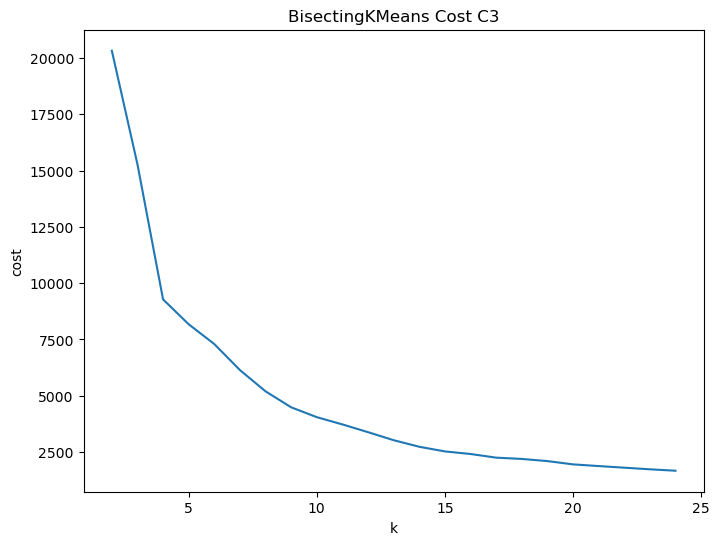

In [16]:
# plot cost-cluster diagram
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,25),cost[2:25])
ax.set_xlabel('k')
ax.set_ylabel('cost')
plt.title('BisectingKMeans Cost C3')

In [17]:
k = 3
pkm = BisectingKMeans().setK(k).setFeaturesCol("features")
model = pkm.fit(new_df)
centers = model.clusterCenters()
transformed=model.transform(new_df)
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[14.08612903 12.25129032]
[19.12266667 24.69533333]
[26.44390244 15.93414634]


In [18]:
dfcent = pd.DataFrame(centers, columns=['x', 'y'])
dfp = new_df.toPandas()
dfp=dfp.iloc[:, [0,1]].values
y_kmeans=transformed.toPandas()['prediction']

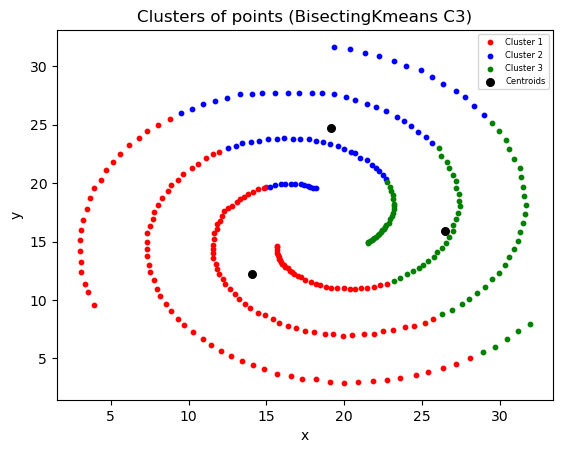

In [19]:
#6 Visualising the clusters
plt.scatter(dfp[y_kmeans==0, 0], dfp[y_kmeans==0, 1], s=10, c='red', label ='Cluster 1')
plt.scatter(dfp[y_kmeans==1, 0], dfp[y_kmeans==1, 1], s=10, c='blue', label ='Cluster 2')
plt.scatter(dfp[y_kmeans==2, 0], dfp[y_kmeans==2, 1], s=10, c='green', label ='Cluster 3')

plt.scatter(dfcent['x'], dfcent['y'], s=30, c='black', label = 'Centroids')
plt.title('Clusters of points (BisectingKmeans C3)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(prop={'size': 6})
plt.show()

In [28]:
import time
list=[]
for i in range(1,5):
    j=1
    start_time = time.time()
    spark=SparkSession.builder.master("local["+str(j)+"]").appName("C3").getOrCreate()
    sc=spark.sparkContext
    data=sc.textFile("C3.txt")
    from numpy import array
    data = data.map(lambda line: [float(x) for x in line.split('\t')]).cache()
    df = spark.createDataFrame(data,["x","y"])
    vecAssembler = VectorAssembler(inputCols=["x", "y"], outputCol="features")
    new_df = vecAssembler.transform(df)
    k = 6
    pkm = KMeans(initMode='k-means||').setK(k).setFeaturesCol("features")
    model = pkm.fit(new_df)
    print("The number of cores: ",i,", Execution time: ","%s seconds" % (time.time() - start_time))
    list.append((time.time() - start_time))

The number of cores:  1 , Execution time:  1.305917501449585 seconds
The number of cores:  2 , Execution time:  1.2192668914794922 seconds
The number of cores:  3 , Execution time:  1.2777106761932373 seconds
The number of cores:  4 , Execution time:  1.1585962772369385 seconds


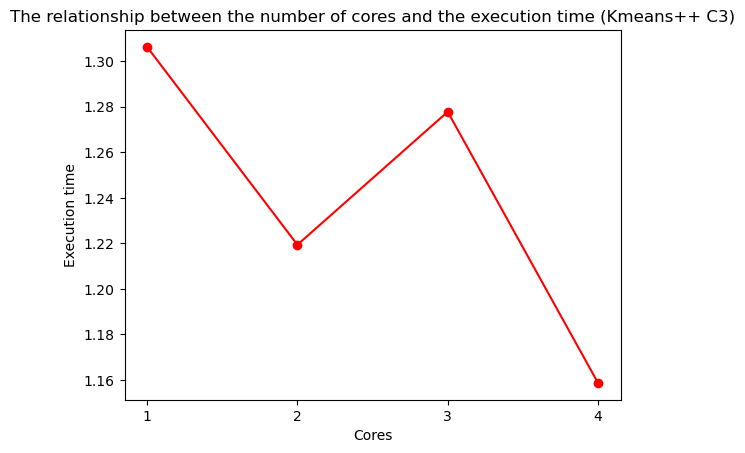

In [29]:
import matplotlib.pyplot as plt
core = ['1','2','3','4']
plt.plot(core, list,marker = 'o',c='red')
plt.xlabel('Cores')
plt.ylabel('Execution time')
plt.title('The relationship between the number of cores and the execution time (Kmeans++ C3)')
plt.show()

In [30]:
import time
list=[]
for i in range(1,5):
    j=1
    start_time = time.time()
    spark=SparkSession.builder.master("local["+str(j)+"]").appName("C3").getOrCreate()
    sc=spark.sparkContext
    data=sc.textFile("C3.txt")
    from numpy import array
    data = data.map(lambda line: [float(x) for x in line.split('\t')]).cache()
    df = spark.createDataFrame(data,["x","y"])
    vecAssembler = VectorAssembler(inputCols=["x", "y"], outputCol="features")
    new_df = vecAssembler.transform(df)
    k = 3
    pkm = BisectingKMeans().setK(k).setFeaturesCol("features")
    model = pkm.fit(new_df)
    print("The number of cores: ",i,", Execution time: ","%s seconds" % (time.time() - start_time))
    list.append((time.time() - start_time))

The number of cores:  1 , Execution time:  1.8169074058532715 seconds
The number of cores:  2 , Execution time:  1.8097529411315918 seconds
The number of cores:  3 , Execution time:  1.5792417526245117 seconds
The number of cores:  4 , Execution time:  1.6809933185577393 seconds


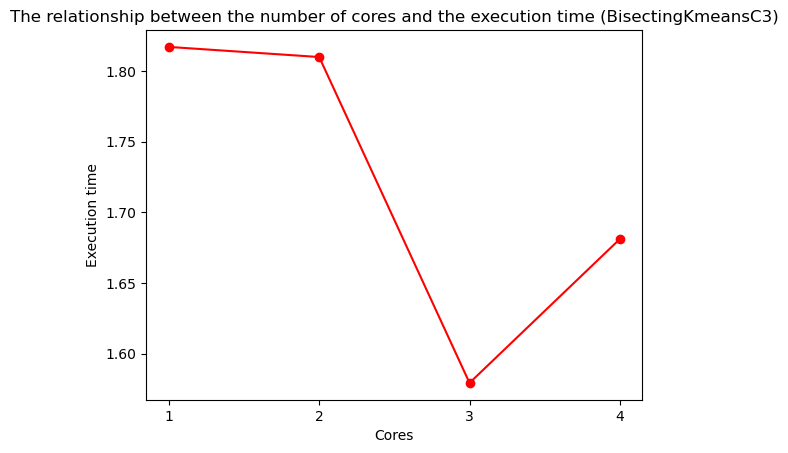

In [31]:
import matplotlib.pyplot as plt
core = ['1','2','3','4']
plt.plot(core, list,marker = 'o',c='red')
plt.xlabel('Cores')
plt.ylabel('Execution time')
plt.title('The relationship between the number of cores and the execution time (BisectingKmeansC3)')
plt.show()